In [74]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns

### Data prep

In [53]:
#load data
df_raw = pd.read_csv('Weekly_Data.csv')

#reduce number of columns
df_raw = df_raw[['Cat_id', 'Season', 'Total', 'propActive',
       'propLying', 'propSitting', 'propStanding', 'propGrooming',
       'propLittering', 'propEating', 'propScratching', 'Cat_Age', 'Cat_Sex',
       'BW', 'BCS', 'BCS_ord', 'Housing', 'Area', 'Diet', 'Coat', 'Owner',
       'Owner_Age', 'Children', 'Cat1', 'Cat2', 'Dog' ]]
df_raw.columns = df_raw.columns.str.lower()
col_names = {'cat_id':'cat_id', 'season': 'season', 'total': 'total', 'propactive': 'prop_active', 'proplying':'prop_lying', 
              'propsitting': 'prop_sitting', 'propstanding': 'prop_standing',
            'propgrooming': 'prop_grooming', 'proplittering': 'prop_littering', 'propeating': 'prop_eating', 
            'propscratching': 'prop_scratching', 'cat_age':  'cat_age', 'cat_sex': 'cat_sex', 
            'bw': 'bw', 'bcs':  'bcs', 'bcs_ord': 'bcs_ord', 'housing': 'housing', 'area': 'area', 
            'diet': 'diet', 'coat': 'coat', 'owner': 'owner', 'owner_age': 'owner_age', 'children': 'children', 
            'cat1': 'cat1', 'cat2': 'cat2', 'dog': 'dog'}
df_raw.columns = df_raw.columns.map(col_names)

#prepare
columns = ['prop_active', 'prop_lying', 'prop_sitting','prop_standing',
            'prop_grooming', 'prop_littering', 'prop_eating', 'prop_scratching']
for column in df_raw[columns]:
    df_raw[column] = [round(i,3)*100 for i in df_raw[column]]

#caculate total 'laziness' = time lying or sitting
df_raw["prop_lazy"] = df_raw[['prop_lying', 'prop_sitting']].sum(axis=1)

#get top3 poses
def get_nth_largest(row, n):
    sorted_row = row.dropna().sort_values(ascending=False)
    if len(sorted_row) >= n:
        return pd.Series({
            f"pose{n}_value": sorted_row.iloc[n - 1],
            f"pose{n}_column": sorted_row.index[n - 1]
        })
    else:
        return pd.Series({
            f"pose{n}_value": np.nan,
            f"pose{n}_column": None
        })

df_raw[["pose1_value", "pose1"]] =  df_raw[columns].apply(
    lambda row: get_nth_largest(row, 1), axis=1)
df_raw[["pose2_value", "pose2"]] =  df_raw[columns].apply(
    lambda row: get_nth_largest(row, 2), axis=1)
df_raw[["pose3_value", "pose3"]] =  df_raw[columns].apply(
    lambda row: get_nth_largest(row, 3), axis=1)
df_raw["pose_other_value"] = 100 - df_raw[["pose1_value", "pose3_value", "pose3_value"]].sum(axis=1)

df_raw.head()

,cat_id,season,total,prop_active,prop_lying,prop_sitting,prop_standing,prop_grooming,prop_littering,prop_eating,...,cat2,dog,prop_lazy,pose1_value,pose1,pose2_value,pose2,pose3_value,pose3,pose_other_value
0,Cat1,Summer,604801,4.5,18.0,46.5,15.2,11.0,0.0,4.6,...,Single,Yes,64.5,46.5,prop_sitting,18.0,prop_lying,15.2,prop_standing,23.1
1,Cat10,Summer,604801,5.4,36.2,35.5,8.0,8.5,0.1,6.1,...,Single,Yes,71.7,36.2,prop_lying,35.5,prop_sitting,8.5,prop_grooming,46.8
2,Cat11,Summer,604801,5.6,21.6,57.2,8.4,5.6,0.1,1.4,...,Multi,No,78.8,57.2,prop_sitting,21.6,prop_lying,8.4,prop_standing,26.0
3,Cat12,Summer,604801,4.2,32.2,47.3,8.5,4.9,0.0,2.8,...,Multi,No,79.5,47.3,prop_sitting,32.2,prop_lying,8.5,prop_standing,35.7
4,Cat13,Summer,604801,2.4,45.4,23.9,17.4,2.9,0.0,8.0,...,Single,Yes,69.3,45.4,prop_lying,23.9,prop_sitting,17.4,prop_standing,19.8


In [203]:
#get aggregates by cat
df = df_raw.groupby("cat_id").agg({'prop_active':"mean", 'prop_lying':"mean", 'prop_sitting':"mean",
       'prop_standing':"mean", 'prop_grooming':"mean", 'prop_littering':"mean", 'prop_eating':"mean",
       'prop_scratching':"mean", 'cat_age':"first", 'cat_sex':"first", 'bw':"first", 'bcs':"first", 'bcs_ord':"first",
       'housing':"first", 'area':"first", 'diet':"first", 'coat':"first", 'owner':"first", 'owner_age':"first", 'children':"first",
       'cat1':"first", 'cat2':"first", 'dog':"first",
}).reset_index()

#top 3 poses
df[["pose1_value", "pose1"]] =  df[columns].apply(
    lambda row: get_nth_largest(row, 1), axis=1)
df[["pose2_value", "pose2"]] =  df[columns].apply(
    lambda row: get_nth_largest(row, 2), axis=1)
df[["pose3_value", "pose3"]] =  df[columns].apply(
    lambda row: get_nth_largest(row, 3), axis=1)
df["pose_other_value"] = 100 - df[["pose1_value", "pose3_value", "pose3_value"]].sum(axis=1)

#caculate total 'laziness' = time lying or sitting
df["prop_lazy"] = df[['prop_lying', 'prop_sitting']].sum(axis=1)

#merge summer and winter data
df = pd.merge(df, 
              df_raw[df_raw["season"]=="Summer"][["cat_id", "prop_lazy",'pose1_value', 'pose1',
                                                   'pose2_value', 'pose2', 'pose3_value', 'pose3', 
                                                   "pose_other_value", 'prop_lying', 'prop_sitting',
                                                   'prop_standing']],
              how="left", suffixes=["", "_summer"],
              left_on="cat_id", right_on="cat_id")

df = pd.merge(df, 
              df_raw[df_raw["season"]=="Winter"][["cat_id", "prop_lazy",'pose1_value', 'pose1', 
                                                  'pose2_value', 'pose2', 'pose3_value', 'pose3',
                                                    "pose_other_value", 'prop_lying', 'prop_sitting',
                                                   'prop_standing']],
              how="left", suffixes=["", "_winter"],
              left_on="cat_id", right_on="cat_id")

#more lazy in summer or winter
df["lazy_season"] = df[["prop_lazy_summer", "prop_lazy_winter"]].idxmax(axis=1).str.split("_").str[2]
df["lazy_diff"] = (df["prop_lazy_winter"] - df["prop_lazy_summer"])

#convert weight rating into dummy variables (5=Ideal > no stripes, 6=Overweight, 7=Heavy, 8=Obese > 3 stripes)
df["stripe1"] = [1 if i > 5 else 0 for i in df["bcs"]]
df["stripe2"] = [1 if i > 6 else 0 for i in df["bcs"]]
df["stripe3"] = [1 if i > 7 else 0 for i in df["bcs"]]

#clean up pose values
for column in ['pose1', 'pose2', 'pose3', 'pose1_summer', 'pose2_summer', 'pose3_summer',
               'pose1_winter', 'pose2_winter', 'pose3_winter']:
    df[column] = [i.split("_")[1] for i in df[column]]

df.head()

,cat_id,prop_active,prop_lying,prop_sitting,prop_standing,prop_grooming,prop_littering,prop_eating,prop_scratching,cat_age,...,pose3_winter,pose_other_value_winter,prop_lying_winter,prop_sitting_winter,prop_standing_winter,lazy_season,lazy_diff,stripe1,stripe2,stripe3
0,Cat1,3.50,39.95,27.65,12.5,7.20,0.00,9.10,0.15,Junior,...,standing,18.5,61.9,8.8,9.8,winter,6.2,1,1,0
1,Cat10,3.50,40.70,26.40,13.7,6.20,0.10,9.25,0.20,Mature,...,sitting,20.2,45.2,17.3,19.4,summer,-9.2,1,1,0
2,Cat11,3.95,39.05,36.55,9.1,4.85,0.05,6.35,0.10,Junior,...,eating,20.9,56.5,15.9,9.8,summer,-6.4,1,1,0
3,Cat12,3.10,36.65,33.60,16.6,4.05,0.00,5.95,0.05,Prime,...,sitting,19.1,41.1,19.9,24.7,summer,-18.5,0,0,0
4,Cat13,2.40,53.40,17.70,13.8,3.20,0.00,9.50,0.00,Prime,...,eating,16.6,61.4,11.5,10.2,winter,3.6,0,0,0


In [204]:
#cat names 
#names come from Blue Cross charity https://www.bluecross.org.uk/advice/cat/wellbeing-and-care/top-cat-names
#import random
#random.shuffle(names_females)
names_females = ['Fuzzy', 'Tilly', 'Patches', 'Lilly', 'Pumpkin', 'Luna', 'Fluffy',
                'Bella', 'Molly', 'Bubbles', 'Smudge', 'Misty', 'Poppy', 'Fudge',
                'Daisy', 'Lily', 'Boo']
names_males = ['Inky', 'Charlie', 'Ralph', 'Finley', 'Tabby', 'Marbles', 'Lucky',
                'Oscar', 'Socks', 'Felix', 'Buddy']

#assign random cat name
female_iter = iter(names_females)
male_iter = iter(names_males)
def assign_name(gender):
    if gender == 'Neutered female':
        return next(female_iter, 'Unnamed_Female')
    elif gender == 'Neutered male':
        return next(male_iter, 'Unnamed_Male')
    else:
        return 'Unknown'
df['cat_name'] = df['cat_sex'].apply(assign_name)

In [205]:
#export to json
df.to_json(orient='records')

'[{"cat_id":"Cat1","prop_active":3.5,"prop_lying":39.95,"prop_sitting":27.65,"prop_standing":12.5,"prop_grooming":7.2,"prop_littering":0.0,"prop_eating":9.1,"prop_scratching":0.15,"cat_age":"Junior","cat_sex":"Neutered male","bw":5.0,"bcs":7.0,"bcs_ord":"Heavy","housing":"Indoor Outdoor","area":"Rural","diet":"Mix","coat":"Short","owner":"Owner2","owner_age":"25 - 34 years","children":"No","cat1":"One","cat2":"Single","dog":"Yes","pose1_value":39.95,"pose1":"lying","pose2_value":27.65,"pose2":"sitting","pose3_value":12.5,"pose3":"standing","pose_other_value":35.05,"prop_lazy":67.6,"prop_lazy_summer":64.5,"pose1_value_summer":46.5,"pose1_summer":"sitting","pose2_value_summer":18.0,"pose2_summer":"lying","pose3_value_summer":15.2,"pose3_summer":"standing","pose_other_value_summer":23.1,"prop_lying_summer":18.0,"prop_sitting_summer":46.5,"prop_standing_summer":15.2,"prop_lazy_winter":70.7,"pose1_value_winter":61.9,"pose1_winter":"lying","pose2_value_winter":13.6,"pose2_winter":"eating","p

### Data checks

In [71]:
#convert % to hours
24/100 * 7.20 #hours
24/100 * 7.20 * 60 # minutes

103.67999999999999

In [61]:
df.head()

,cat_id,prop_active,prop_lying,prop_sitting,prop_standing,prop_grooming,prop_littering,prop_eating,prop_scratching,cat_age,...,pose2_winter,pose3_value_winter,pose3_winter,pose_other_value_winter,lazy_season,lazy_diff,stripe1,stripe2,stripe3,cat_name
0,Cat1,3.50,39.95,27.65,12.5,7.20,0.00,9.10,0.15,Junior,...,eating,9.8,standing,18.5,winter,6.2,1,1,0,Inky
1,Cat10,3.50,40.70,26.40,13.7,6.20,0.10,9.25,0.20,Mature,...,standing,17.3,sitting,20.2,summer,-9.2,1,1,0,Fuzzy
2,Cat11,3.95,39.05,36.55,9.1,4.85,0.05,6.35,0.10,Junior,...,sitting,11.3,eating,20.9,summer,-6.4,1,1,0,Tilly
3,Cat12,3.10,36.65,33.60,16.6,4.05,0.00,5.95,0.05,Prime,...,standing,19.9,sitting,19.1,summer,-18.5,0,0,0,Charlie
4,Cat13,2.40,53.40,17.70,13.8,3.20,0.00,9.50,0.00,Prime,...,sitting,11.0,eating,16.6,winter,3.6,0,0,0,Patches


In [28]:
df.columns

Index(['cat_id', 'prop_active', 'prop_lie', 'prop_sit', 'prop_stand',
       'prop_groom', 'prop_litter', 'prop_eat', 'prop_scratch', 'cat_age',
       'cat_sex', 'bw', 'bcs', 'bcs_ord', 'housing', 'area', 'diet', 'coat',
       'owner', 'owner_age', 'children', 'cat1', 'cat2', 'dog', 'pose1_value',
       'pose1', 'pose2_value', 'pose2', 'pose3_value', 'pose3',
       'pose_other_value', 'prop_lazy', 'prop_lazy_summer',
       'pose1_value_summer', 'pose1_summer', 'pose2_value_summer',
       'pose2_summer', 'pose3_value_summer', 'pose3_summer',
       'pose_other_value_summer', 'prop_lazy_winter', 'pose1_value_winter',
       'pose1_winter', 'pose2_value_winter', 'pose2_winter',
       'pose3_value_winter', 'pose3_winter', 'pose_other_value_winter',
       'lazy_season', 'lazy_diff', 'stripe1', 'stripe2', 'stripe3',
       'cat_name'],
      dtype='object')

In [63]:
df["lazy_season"].value_counts()

summer    15
winter    13
Name: lazy_season, dtype: int64

In [71]:
df[['stripe1', 'stripe2', 'stripe3']].sum()

stripe1    17
stripe2     8
stripe3     1
dtype: int64

In [53]:
df[["pose1", "pose2", "pose3"]].value_counts()

pose1        pose2         pose3       
propSitting  propLying     propStanding    14
propLying    propSitting   propStanding    13
             propStanding  propSitting      1
dtype: int64

In [54]:
df[["pose1_winter", "pose2_winter", "pose3_winter"]].value_counts()

pose1_winter  pose2_winter  pose3_winter
propSitting   propLying     propStanding    14
propLying     propSitting   propStanding     6
              propStanding  propSitting      5
              propSitting   propEating       2
              propEating    propStanding     1
dtype: int64

In [55]:
df[["pose1_summer", "pose2_summer", "pose3_summer"]].value_counts()

pose1_summer  pose2_summer  pose3_summer
propLying     propSitting   propStanding    12
propSitting   propLying     propStanding    10
                            propGrooming     2
propLying     propSitting   propEating       1
                            propGrooming     1
              propStanding  propSitting      1
propSitting   propLying     propEating       1
dtype: int64

In [161]:
df["propLazy"].describe()

count    28.000000
mean     73.307143
std       5.931003
min      59.350000
25%      69.800000
50%      74.175000
75%      76.987500
max      84.300000
Name: propLazy, dtype: float64

## Exploration

In [74]:
df.columns

Index(['Cat_id', 'propActive', 'propLying', 'propSitting', 'propStanding',
       'propGrooming', 'propLittering', 'propEating', 'propScratching',
       'Cat_Age', 'Cat_Sex', 'BW', 'BCS', 'BCS_ord', 'Housing', 'Area', 'Diet',
       'Coat', 'Owner', 'Owner_Age', 'Children', 'Cat1', 'Cat2', 'Dog',
       'pose1_value', 'pose1', 'pose2_value', 'pose2', 'pose3_value', 'pose3',
       'pose_other_value', 'propLazy', 'propLazy_summer', 'pose1_value_summer',
       'pose1_summer', 'pose2_value_summer', 'pose2_summer',
       'pose3_value_summer', 'pose3_summer', 'pose_other_value_summer',
       'propLazy_winter', 'pose1_value_winter', 'pose1_winter',
       'pose2_value_winter', 'pose2_winter', 'pose3_value_winter',
       'pose3_winter', 'pose_other_value_winter', 'lazy_season', 'stripe1',
       'stripe2', 'stripe3'],
      dtype='object')

### Lily profile

In [206]:
id = df[df["prop_lazy"] == df["prop_lazy"].sort_values().reset_index(drop=True)[13]]["cat_id"]
id

25    Cat7
Name: cat_id, dtype: object

In [225]:
lily = df[df["cat_id"]=="Cat7"][['prop_lying', 'prop_sitting', 'prop_standing', 'prop_lying_summer', 'prop_sitting_summer',
       'prop_standing_summer', 'prop_lying_winter', 'prop_sitting_winter', 'prop_standing_winter']].transpose().reset_index()
lily["position"] = lily["index"].str.split("_").str[1]
lily["season"] = [i[-1] if len(i)==3 else "average" for i in lily["index"].str.split("_")]
lily = lily.drop(columns=["index"]).rename(columns={25: "value"})
lily

,value,position,season
0,37.00,lying,average
1,36.95,sitting,average
2,12.45,standing,average
3,36.90,lying,summer
4,33.70,sitting,summer
5,14.30,standing,summer
6,37.10,lying,winter
7,40.20,sitting,winter
8,10.60,standing,winter


In [229]:
lily.to_json(orient="index")

'{"0":{"value":37.0,"position":"lying","season":"average"},"1":{"value":36.95,"position":"sitting","season":"average"},"2":{"value":12.45,"position":"standing","season":"average"},"3":{"value":36.9,"position":"lying","season":"summer"},"4":{"value":33.7,"position":"sitting","season":"summer"},"5":{"value":14.3,"position":"standing","season":"summer"},"6":{"value":37.1,"position":"lying","season":"winter"},"7":{"value":40.2,"position":"sitting","season":"winter"},"8":{"value":10.6,"position":"standing","season":"winter"}}'

In [207]:
df[df["cat_id"]=="Cat7"].transpose()

,25
cat_id,Cat7
prop_active,1.5
prop_lying,37.0
prop_sitting,36.95
prop_standing,12.45
prop_grooming,8.15
prop_littering,0.0
prop_eating,3.65
prop_scratching,0.2
cat_age,Prime


### Dotplots

In [119]:
df[['prop_lying', 'prop_sitting', 'prop_standing',
    'prop_grooming', 'prop_eating', 'prop_littering',  'prop_scratching']].mean()

prop_lying         36.708929
prop_sitting       36.598214
prop_standing      12.714286
prop_grooming       5.483929
prop_eating         5.482143
prop_littering      0.026786
prop_scratching     0.121429
dtype: float64

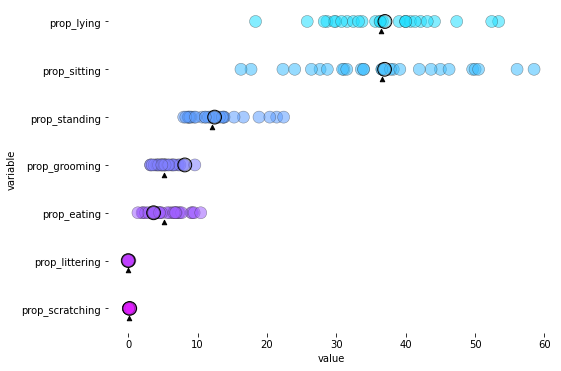

In [148]:
cols_analysis = ['prop_lying', 'prop_sitting', 'prop_standing',
       'prop_grooming', 'prop_eating', 'prop_littering',  'prop_scratching']
df_long = pd.melt(
    df, id_vars='cat_id',
    value_vars=cols_analysis,
    var_name='variable', value_name='value'
)
avg = df[cols_analysis].median().values
lily = df[df["cat_name"]=="Lily"][cols_analysis]

#plot -------------
fig, ax = plt.subplots(figsize=(8,6))

ax.scatter(avg, [i+0.2 for i in [0, 1, 2, 3, 4, 5, 6]], marker="^", color="black", s=20)
sns.stripplot(
    data=df_long, x="value", y='variable', 
    jitter=0, s=12, marker="o", linewidth=0.5, alpha=.55,
    edgecolor="#333333", zorder=1, ax=ax, palette="cool"
)
for pos in ["top", "left", "right", "bottom"]:
    ax.spines[pos].set_visible(False)


ax.scatter(lily.values, [0, 1, 2, 3, 4, 5, 6], marker="o", color="None",s=190, edgecolor="black")

### Flow chart

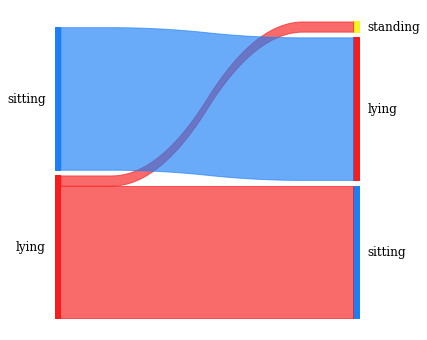

In [159]:
from pySankey.sankey import sankey

colors = {
    "lying": "#f71b1b",
    "sitting": "#1b7ef7",
    "standing": "#f3f71b",
    "grooming": "#12e23f",
    "eating": "#f78c1b"
}

sankey(df["pose1"], df["pose2"], aspect=20, colorDict=colors, fontsize=12)

In [177]:
df[["pose2","pose3"]].value_counts()

pose2     pose3   
lying     standing    14
sitting   standing    13
standing  sitting      1
dtype: int64

In [ ]:
import plotly.graph_objects as go

label_list = ['lying', 'sitting',  'lying', 'sitting', 'standing', 'standing', 'sitting' ]

# Pose 1: lying: 0, sitting: 1, 
# Pose 2: lying: 2, sitting: 3, standing: 4, 
# Pose 3: standing: 5, sitting: 6

source = [1, 0, 0, 2, 3, 4]
target = [2, 3, 4, 5, 5, 6]
count = [14, 13, 1, 14, 13, 1]

fig = go.Figure(data=[go.Sankey(
    node = {"label": label_list},
    link = {"source": source, "target": target, "value": count}
    )])
fig.show()

In [187]:
df[["pose2_summer","pose3_summer"]].value_counts()

pose2_summer  pose3_summer
sitting       standing        12
lying         standing        10
              grooming         2
              eating           1
sitting       eating           1
              grooming         1
standing      sitting          1
dtype: int64

In [ ]:
#SUMMER
label_list = ['lying', 'sitting',  
              'lying', 'sitting', 'standing', 
              'standing', 'sitting', 'grooming', 'eating' ]

# Pose 1: lying: 0, sitting: 1, 
# Pose 2: lying: 2, sitting: 3, standing: 4, 
# Pose 3: standing: 5, sitting: 6, grooming: 7, eating: 8

source = [0, 0, 1, 2, 2, 2, 3, 3, 3, 4]
target = [3, 4, 2, 5, 7, 8, 5, 7, 8, 6]
count = [14, 1, 13, 10, 2, 1, 12, 1, 1, 1]

fig = go.Figure(data=[go.Sankey(
    node = {"label": label_list},
    link = {"source": source, "target": target, "value": count}
    )])
fig.show()

In [194]:
df[["pose2_winter","pose3_winter"]].value_counts()

pose2_winter  pose3_winter
lying         standing        14
sitting       standing         6
standing      sitting          5
sitting       eating           2
eating        standing         1
dtype: int64

In [196]:
#WINTER
label_list = ['lying', 'sitting',  
              'lying', 'sitting', 'standing', 'eating',
              'standing', 'sitting', 'grooming', 'eating' ]

# Pose 1: lying: 0, sitting: 1, 
# Pose 2: lying: 2, sitting: 3, standing: 4, eating: 5
# Pose 3: standing: 6, sitting: 7, grooming: 8, eating: 9

source = [0, 0, 0, 1,   2, 3, 3, 4, 5]
target = [3, 4, 5, 2,   6, 6, 9, 7, 6]
count = [8, 5, 1, 14,   14, 6, 2, 5, 1]

fig = go.Figure(data=[go.Sankey(
    node = {"label": label_list},
    link = {"source": source, "target": target, "value": count}
    )])
fig.show()

### Lazy cats beeswarm

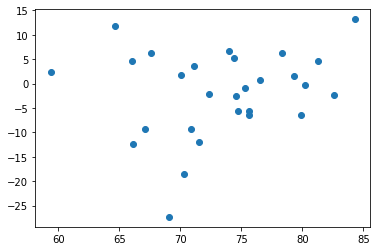

In [151]:
## Scatter
fig, ax = plt.subplots()
ax.scatter(df["propLazy"], df["lazy_diff"])


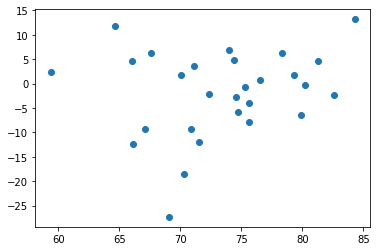

In [153]:
def relax_y_positions(x_vals, y_vals, radius=1, iterations=10):
    y = y_vals.copy()
    for _ in range(iterations):
        for i in range(len(x_vals)):
            for j in range(i + 1, len(x_vals)):
                if abs(x_vals[i] - x_vals[j]) < 1:
                    dy = y[j] - y[i]
                    if abs(dy) < 2 * radius:
                        shift = (2 * radius - abs(dy)) / 2
                        direction = 1 if dy >= 0 else -1
                        y[i] -= shift * direction
                        y[j] += shift * direction
    return y

new_y = relax_y_positions(df["propLazy"], df["lazy_diff"])

## Scatter
fig, ax = plt.subplots()
ax.scatter(df["propLazy"], new_y)